# Predictive Maintenance Project

Predictive maintenance is vital to maintain the health of the assests and predicting possible failures. It uses analytics and machine learning algorithms that monitors the state of machinery. It puts the operational data to use to assess potential malfunctions. This allows organizations to reduce asset failures and their costs.

This project aims at analysing to explore the AI4I Predictive Maintenance Dataset from the UCI Repository and to predict weather or not a machine will fail, as well as the nature of the failure, using different machine learning algorithms.



In [50]:
#load the necessary pacakges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where


In [51]:
# Import data
data_path = 'predictive_maintenance.csv'
data = pd.read_csv(data_path)

## Data Description 
we will use the AI4I Predictive Maintenance Dataset from the UCI Repository[https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset], it is a synthetic dataset as it is difficult to get the predictive maintenance datasets. This dataset contains 10000 instances and 14 features.
the 14 features include:


* UID: unique identifier ranging from 1 to 10000;
* Product ID: consisting of a letter L, M, or H for low (60% of all products), medium (30%)
and high (10%) as product quality variants and a variant-specific serial number;
* Air temperature [K]: generated using a random walk process later normalized to a standard
deviation of 2 K around 300 K;
* Process temperature [K]: generated using a random walk process normalized to a standard
deviation of 1 K, added to the air temperature plus 10 K;
* Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally
distributed noise;
* Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation
of 10 Nm and no negative values;
* Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used
tool in the process;
* Machine failure: label that indicates, whether the machine has failed in this particular data
point for any of the following failure modes are true.

The machine failure consists of five independent failure modes:
* tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear
time between 200 - 240 mins;
* heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below
1380 rpm;
* power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails;
* overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;
* random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process
parameters.

If at least one of the above failure modes is true, the process fails and the ’machine failure’
label is set to 1. It is therefore not transparent to the machine learning method, which of the
failure modes has caused the process to fail.



In [52]:
#lets take  look at the data 
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [53]:
#checking for null values 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [54]:
#checking for duplicates 
print("Are there any duplicate values:",
      len(data['Product ID'])!=len(set(data['Product ID'])))

Are there any duplicate values: False


In [55]:
#set numeric columns dtype to float to make it possible to store floating points
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')

#rename the features so that they are easy to use 
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

We see two ID columns now we cannot identify one machine with two ids during our analysis so we drop these columns.

In [56]:
#make the copy of the dataset and drop the id columns 
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)


Lets check the number of the types of machine we have: 

In [57]:
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
Type_percentage_df = Type_percentage.reset_index()
Type_percentage_df.columns = ['Type', 'Percentage']

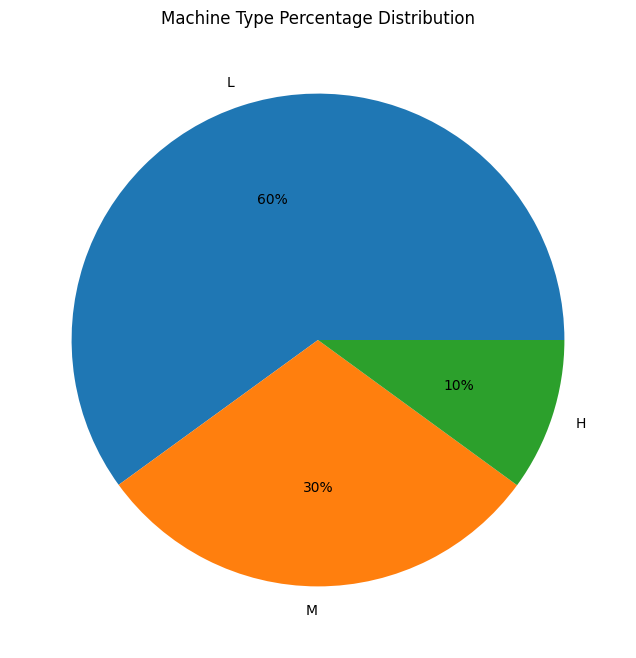

In [58]:
plt.figure(figsize=(8, 8))
plt.pie(Type_percentage_df['Percentage'], labels=Type_percentage_df['Type'], autopct='%.0f%%', colors=sns.color_palette('tab10'))
plt.title('Machine Type Percentage Distribution')
plt.show()

In [59]:
#check the unique values in the failure types 
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [60]:
#lets check the number of random failures of the machine - this data is not very usefull for us and the target is set to 0.
target = ['Target','Failure Type']
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


We will remove these failures as they were random and hence not predictabe. This also implies that they are not of use.

In [61]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


In [62]:
#check for no failures - they are not usefull for our analysis 
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
df.loc[idx_ambiguous]

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1437,H,298.8,309.9,1439.0,45.2,40.0,1,No Failure
2749,M,299.7,309.2,1685.0,28.9,179.0,1,No Failure
4044,M,301.9,310.9,1419.0,47.7,20.0,1,No Failure
4684,M,303.6,311.8,1421.0,44.8,101.0,1,No Failure
5536,M,302.3,311.8,1363.0,54.0,119.0,1,No Failure
5941,L,300.6,310.7,1438.0,48.5,78.0,1,No Failure
6478,L,300.5,309.8,1663.0,29.1,145.0,1,No Failure
8506,L,298.4,309.6,1710.0,27.3,163.0,1,No Failure
9015,L,297.2,308.1,1431.0,49.7,210.0,1,No Failure


In [63]:
#we can drop the records that are assigned 'No Failure'
df.drop(index=idx_ambiguous, inplace=True)

In [64]:
#inspect the outliers - we see that Torque and rotaional speed have outliers 
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


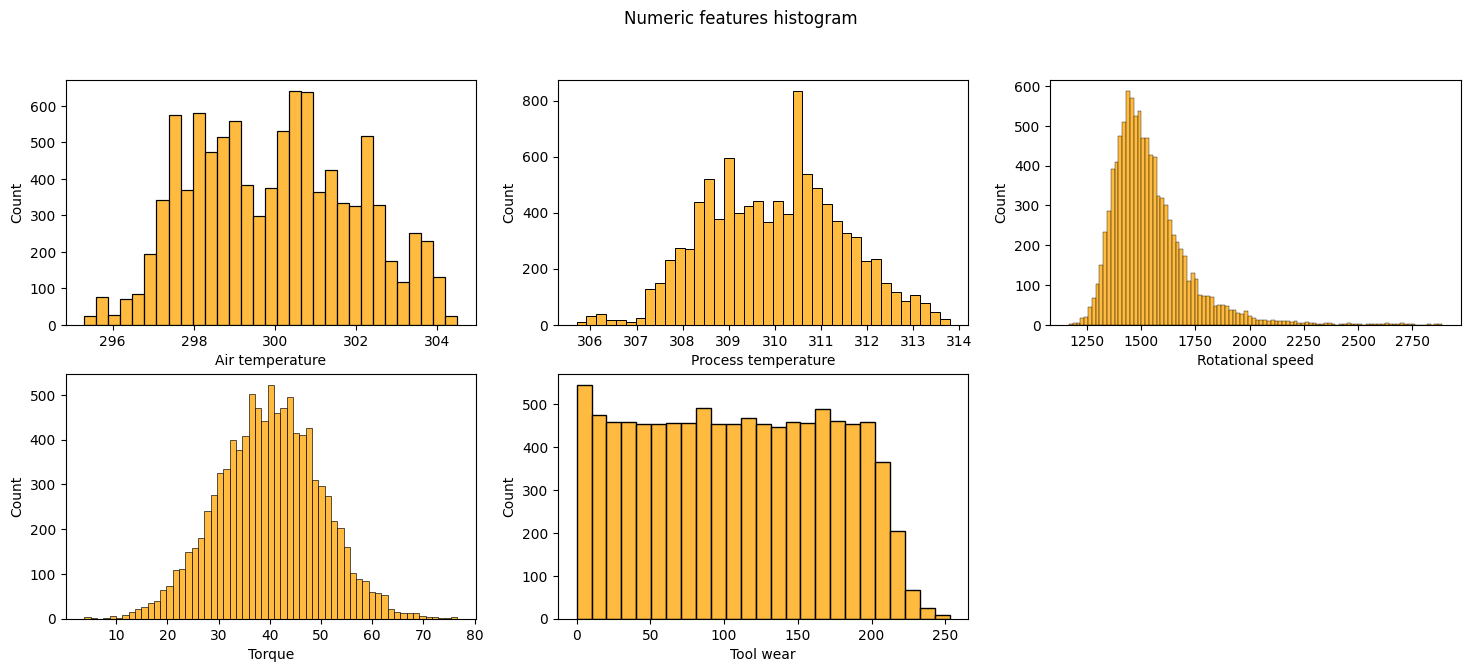

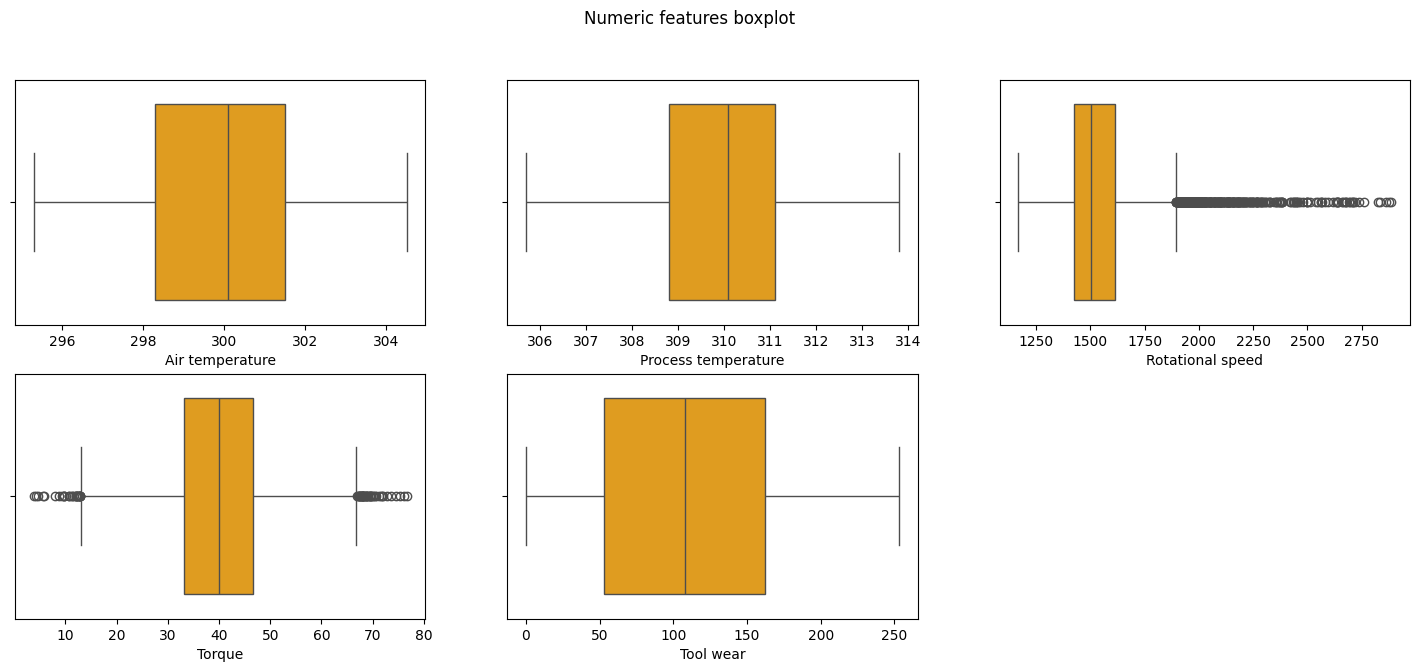

In [65]:
#lets explore the outliers using boxplot and histograms to be sure that Torque and Rotaional speed have the most number of outliers

features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']

#assuming df is your DataFrame and features is a list of feature names
num_features = [feature for feature in features if df[feature].dtype == 'float64']

#histograms of numeric features
plt.figure(figsize=(18, 7))
plt.suptitle('Numeric features histogram')
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=feature,color='orange')

plt.show()

#Boxplot
plt.figure(figsize=(18, 7))
plt.suptitle('Numeric features boxplot')

for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=feature, color='orange',fliersize= 6)

plt.show()


From the above graphs, we can see that the two features, Torque and Rotaional speed have several outliers.

Failures percentage in data: 3.31


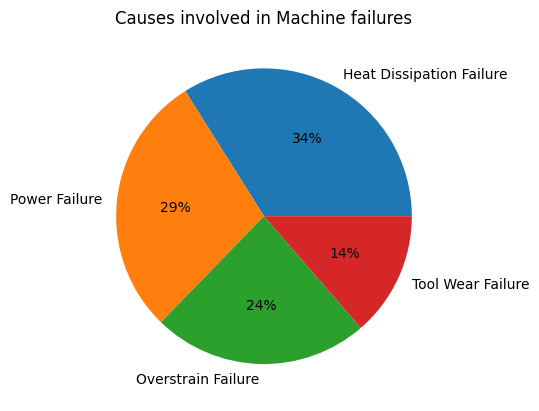

In [66]:

# Identify indices where there is a failure and extract corresponding rows
failure_indices = df[df['Failure Type'] != 'No Failure'].index
df_failures = df.loc[failure_indices]
# Calculate the percentage of each failure type in the subset of failures
failure_percentage = 100 * df_failures['Failure Type'].value_counts() / len(df_failures)
# Display the overall percentage of failures in the entire dataset
total_failures_percentage = round(100 * df['Target'].sum() / len(df), 2)
print('Failures percentage in data:', total_failures_percentage)

# Pie plot to visualize the distribution of failure types
plt.title('Causes involved in Machine failures')
plt.pie(x=failure_percentage.array, labels=failure_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()


From the above pie chart we can clearly see a case of class imbalance, which can be misleading to the model and for us when interpreting the results. To solve this problem we will perform data augnentation using Over-Sampling with SMOTE (Synthetic Minority Oversampling Technique)
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [67]:
from imblearn.over_sampling import SMOTENC

y_failures = df['Failure Type']
X_failures = df.drop(columns=['Failure Type'])

# Summarize class distribution before SMOTE
counter_before = Counter(y_failures)
print("Class distribution before SMOTE:", counter_before)

# Assuming df is your main dataset
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working / 0.8)
spc = round((desired_length - n_working) / 4)  # samples per class

# Resampling using SMOTENC
balance_cause = {'No Failure': n_working,
                 'Overstrain Failure': spc,
                 'Heat Dissipation Failure': spc,
                 'Power Failure': spc,
                 'Tool Wear Failure': spc}

sm = SMOTENC(categorical_features=[0, 7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

# Summarize the new class distribution after SMOTE
counter_after = Counter(y_res)
print("Class distribution after SMOTE:", counter_after)


Class distribution before SMOTE: Counter({'No Failure': 9643, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45})
Class distribution after SMOTE: Counter({'No Failure': 9643, 'Power Failure': 603, 'Tool Wear Failure': 603, 'Overstrain Failure': 603, 'Heat Dissipation Failure': 603})


Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


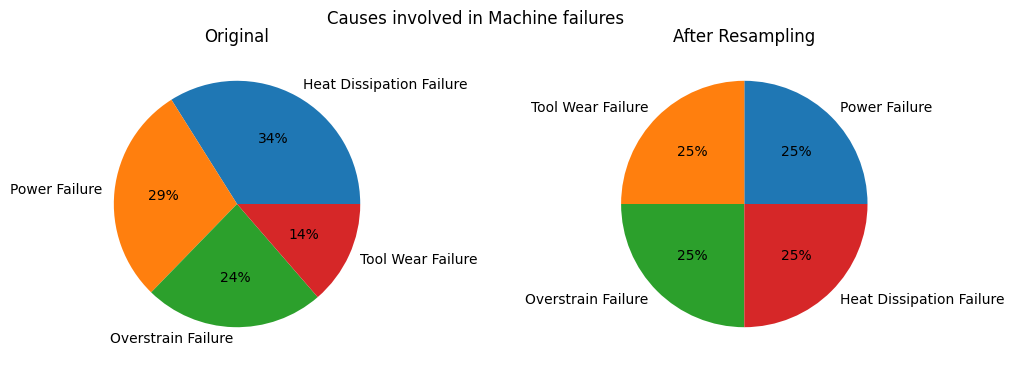

In [68]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=failure_percentage .array, labels=failure_percentage .index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

The frequency of failures also depend on the type of machine, if the machine is old an dnot of good quality it is more likely to have failure than a machine which is of relatively better quality. 
we will now visually inspect the distribution of numeric features in the dataset after applying resampling techniques, specifically focusing on the different types of machine failures.
The interpretation suggests that the imbalance in machine types may contribute to the observed failure patterns.

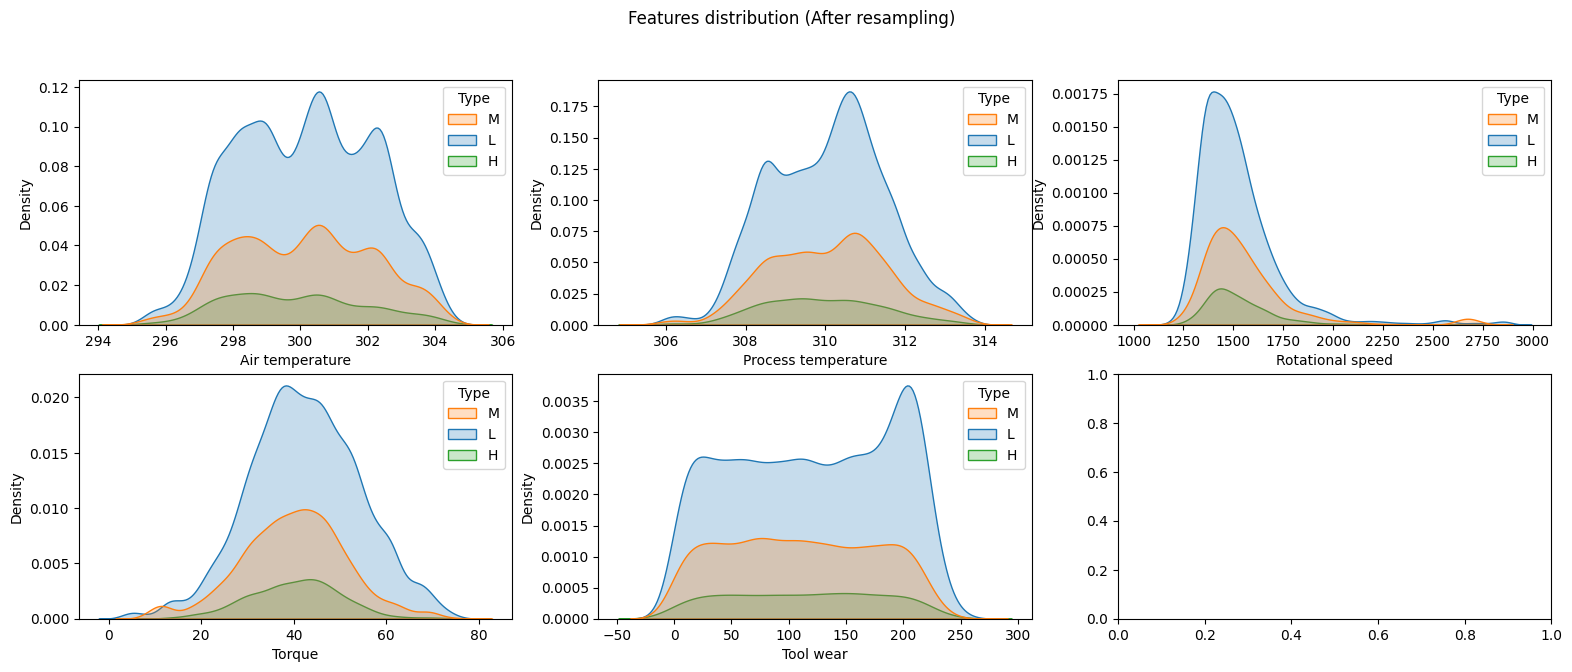

In [69]:
# Kdeplot of numeric features (After resampling) - hue=Type
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

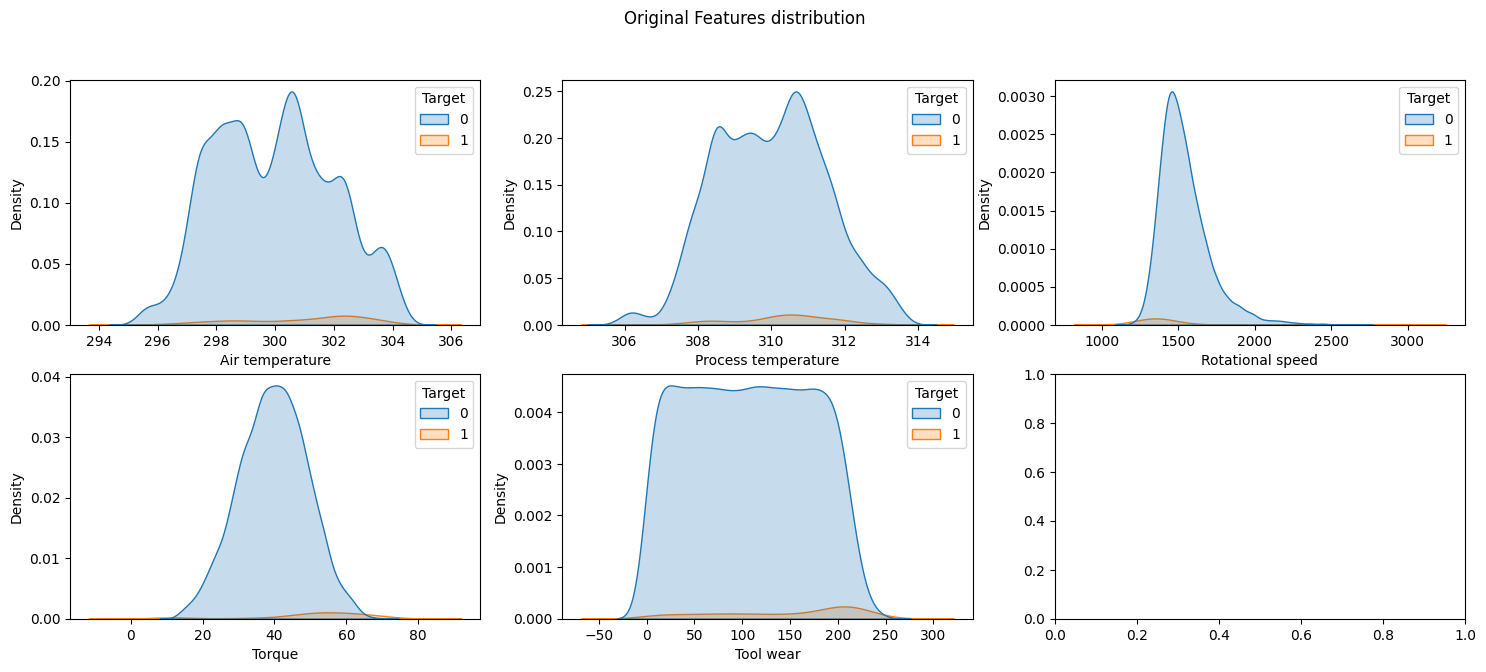

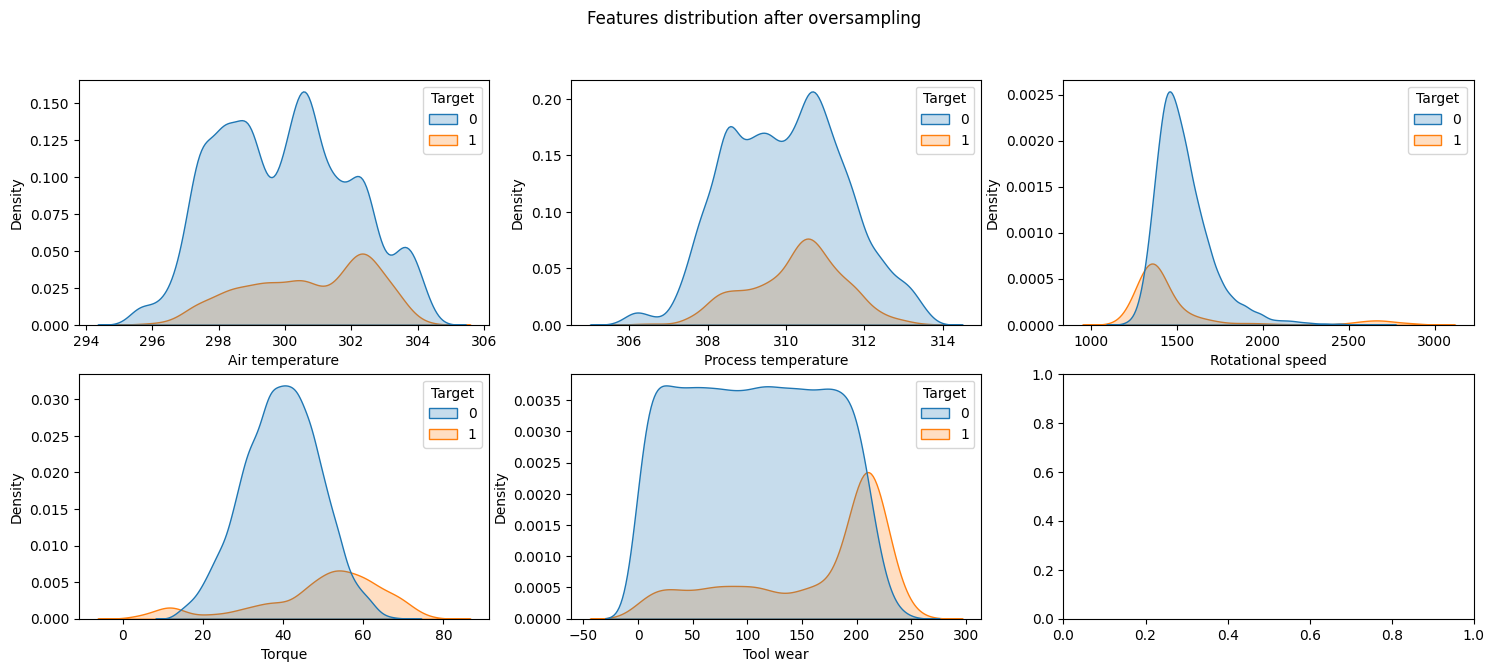

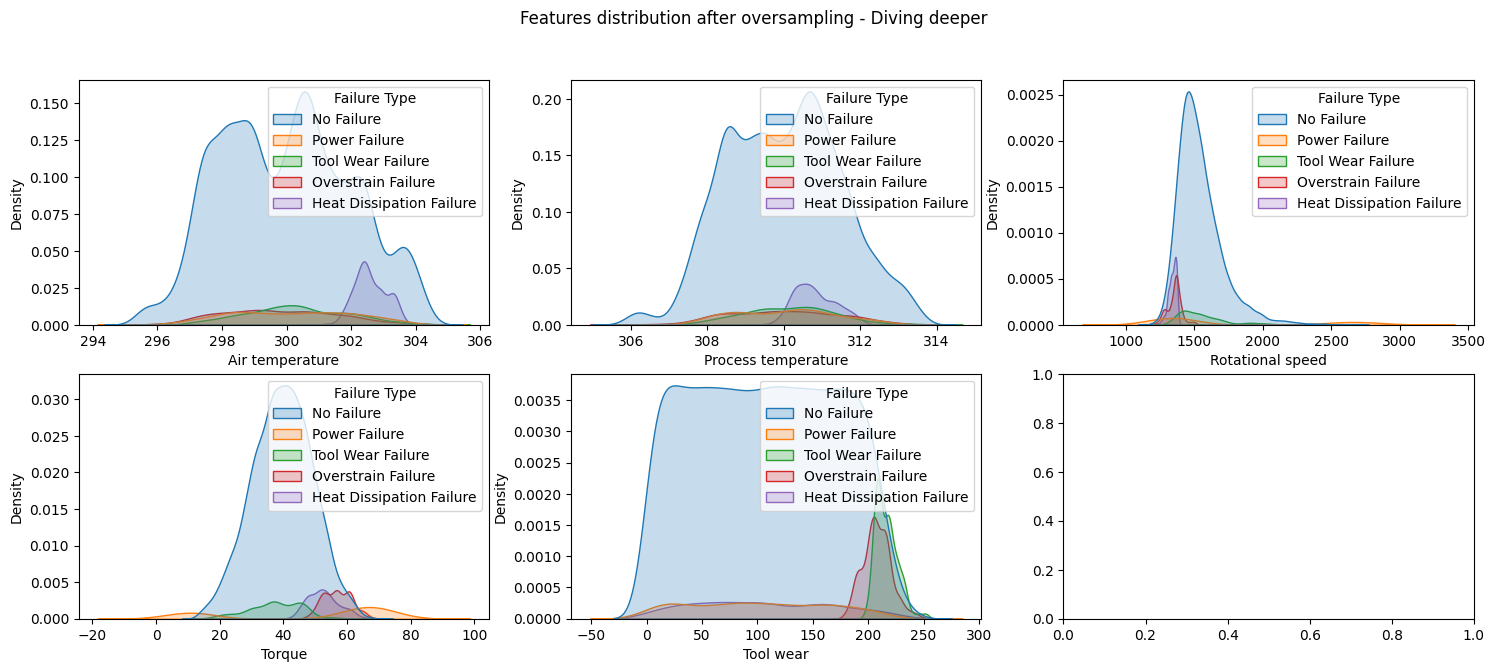

In [70]:
# Kdeplot of numeric features (Original)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Original Features distribution')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature,
                hue='Target', fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Target'], fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling) - Diving deeper
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling - Diving deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Failure Type'], fill=True, palette='tab10')
plt.show()

The interpretation suggests that the imbalance in machine types may contribute to the observed failure patterns.

To prepare the data further, we undertake two transformations:
1. Apply label encoding to categorical columns—Type is treated as an ordinal feature, and Cause is consolidated into a single column. The mapping is as follows:
   - Type: {L=0, M=1, H=2}
   - Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
2. Scale the columns using StandardScaler. This aids the effectiveness of methods relying on the metric space, such as PCA and KNN. Notably, StandardScaler is observed to yield slightly better performance compared to MinMaxScaler.

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

In [72]:
#we move forward with pca
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    37.69
PC2    36.81
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


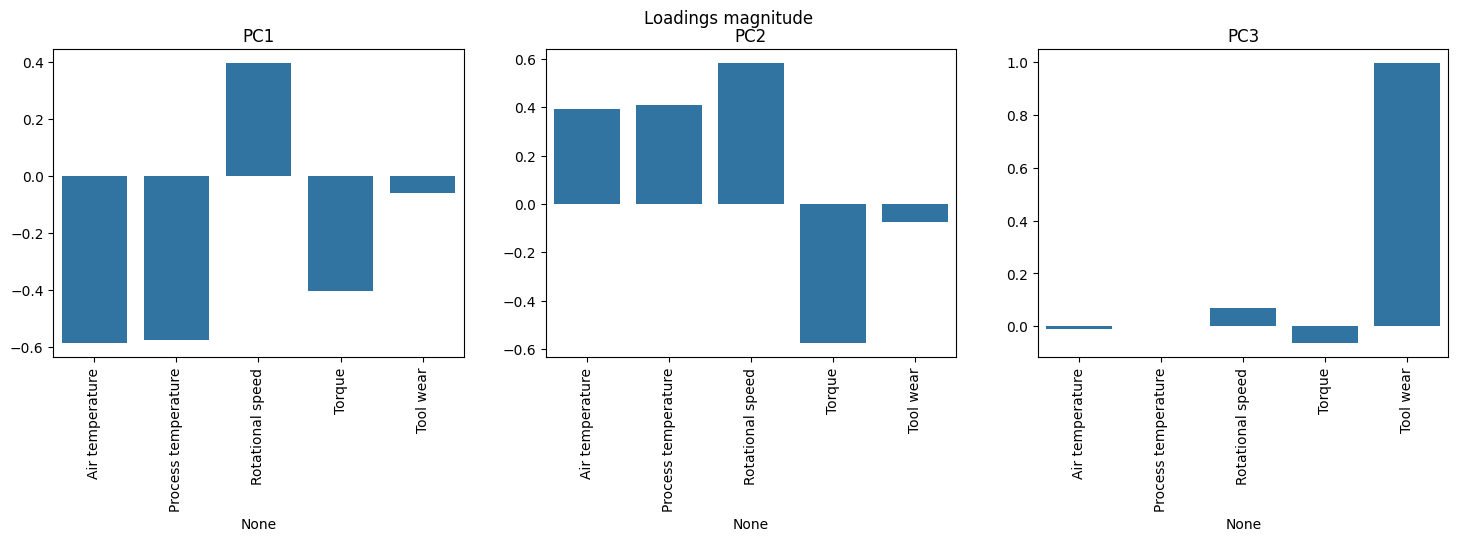

In [73]:
#we will use these three components to represent the variance of the data.
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()  

The bar plot of Principal Components weights makes easy to understand what they represent:
* PC1 is closely related to the two temperature data;
* PC2 can be identified with the machine power, which is the product of Rotational Speed
and Torque;
* PC3 is identifiable with Tool Wear.

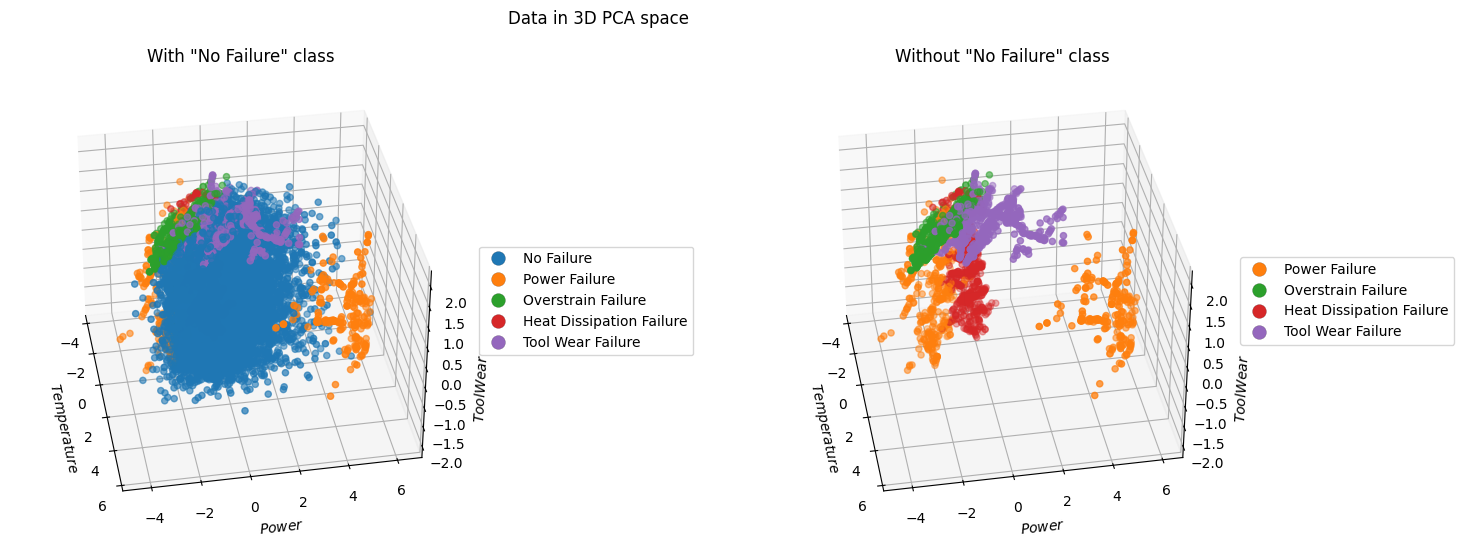

In [74]:
X_pca3.rename(mapper={'PC1':'Temperature',
                      'PC2':'Power',
                      'PC3':'Tool Wear'}, axis=1, inplace=True)

# PCA plot
color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple'})
color.append(col)
idx_w = col[col == 'tab:blue'].index
color.append(col.drop(idx_w))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
labelTups = [('No Failure','tab:blue'),
             ('Power Failure', 'tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure', 'tab:red'),
             ('Tool Wear Failure','tab:purple')]

fig = plt.figure(figsize=(18,6))
fig.suptitle('Data in 3D PCA space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx,idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx,'Temperature'],
                    X_pca3.loc[idx,'Power'],
                    X_pca3.loc[idx,'Tool Wear'],
                    c=color[j])
    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With'+str(j*'out')+' "No Failure" class')
    ax.view_init(35, -10) 
    custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                               mec='k', mfc=c, mew=.1, ms=20) for c in colors[j:]]
    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]], 
              loc='center left', bbox_to_anchor=(1.0, .5))
      
plt.show()

The projection onto the space defined by these three axes reveals the following patterns:
- TWF (Tool Wear Failure) is distinctly separated from other failure classes and is primarily influenced by PC3 (Tool Wear).
- PWF (Power Failure) spans two distinct bands along PC2 (Power) independently of the other components.
- OSF (Overstrain Failure) and HDF (Heat Dissipation Failure) classes show less separation, with OSF characterized by high Tool Wear and low power, while HDF is characterized by high temperature and low power.

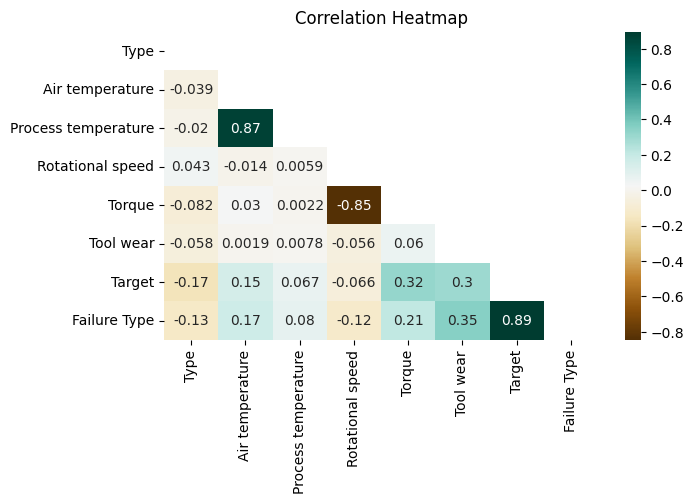

In [75]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()
#we see the correlation between the different features below.

### 2.8) Metrics <a id="metrics"></a>

To evaluate the models we will use from a quantitative point of view, we resort to some metrics
that summarize some characteristics of the classification results:
* Accuracy: expresses the fraction of instances that are classified correctly, it is the most intuitive metric that is usually used in classification tasks.
$$ Accuracy = \frac{TP + TN}{TP + TN + FT + FN} $$
* AUC: can be considered as a measure of the separation between True Positives and True Negatives, that is, the ability of the model to distinguish between classes. In detail, it represents the area below the ROC curve, given by the estimate of the True Positive Rate (Recall) for each possible value of the True Negative Rate).
* F1: reports the classification capacity of the model to Precision and Recall, giving both the same weight.
$$F1 = 2\frac{Precision * Recall}{Precision + Recall}$$
Although generally effective, AUC can be optimistic in the case of highly unbalanced
classes, as happens in the binary task, while the F1 score is more reliable in this kind of scenario.
We consider this last metric particularly significant as it is able to mediate the cases in which
the machines that are about to fail are classified as functioning (Recall) and the one in which
functioning machines are classified as about to suffer a failure (Precision). To be more specific
we will give more importance to Recall than Precision, by evaluating also an "adjusted" version
of the F1 through a β parameter:
$$F_\beta = (1 + \beta^2)\frac{Precision * Recall}{\beta^2  Precision + Recall}$$
With the choice $\beta = 2$ (common in literature) a greater influence of the Recall is obtained.
This choice is motivated by the fact that in order to optimize the costs for the maintenance of
the machinery it is a good thing to limit the purchase of unnecessary replacement materials but
it results far more important to avoid the possibility of having to replace a machinery after it is
broken, since this second scenario generally has higher costs.

## Lets Design the model

In [76]:
df_pre.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,1,-1.015754,-1.001607,0.080702,0.112601,-1.729820,0,0
1,0,-0.965501,-0.932180,-0.560230,0.411567,-1.685422,0,0
2,0,-1.015754,-1.071034,-0.156846,0.676366,-1.655823,0,0
3,0,-0.965501,-1.001607,-0.448179,-0.169282,-1.626224,0,0
4,0,-0.965501,-0.932180,-0.560230,-0.126572,-1.596626,0,0


In [77]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time

# train-validation-test split
X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [78]:

import time
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np

def eval_preds(model, X, y_true, y_pred, task):
    if task == 'binary':
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)[:, 1]
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC': acc, 'AUC': auc, 'F1': f1, 'F2': f2})
    metrics = round(metrics, 3)
    return cm, metrics

def tune_and_fit(clf, X, y, params, task):
    if task == 'binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params, cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task == 'multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params, cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])
        
    print('Best params:', grid_model.best_params_)
    train_time = time.time() - start_time
    mins = int(train_time // 60)
    print('Training time: ' + str(mins) + 'm ' + str(round(train_time - mins * 60)) + 's')
    return grid_model

def predict_and_evaluate(fitted_models, X, y_true, clf_str, task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models, clf_str):
        y_pred[model_name] = fit_model.predict(X)
        if task == 'binary':
            cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics

def fit_models(clf, clf_str, X_train, X_val, y_train, y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train, y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model, X_val, y_val, y_val_pred, 'binary')[1]
    return metrics


Before we move to training the model we will get into feature selection phase where we explore various approaches based on correlation analysis and domain knowledge. Notably, we observed positive correlation between 'Process temperature' and 'Air temperature' and negative correlation between 'Torque' and 'Rotational speed.' Given that 'PWF' and 'HDF' failures are associated with specific conditions involving these features, outright deletion of columns is deemed suboptimal. Instead, we experiment with creating new features by combining pairs of correlated features. The datasets used for model training are as follows:
1. Original dataset.
2. Dataset with 'Process temperature' and 'Air temperature' replaced by their product.
3. Dataset with 'Torque' and 'Rotational speed' replaced by their product.
4. Combined dataset incorporating the above operations.

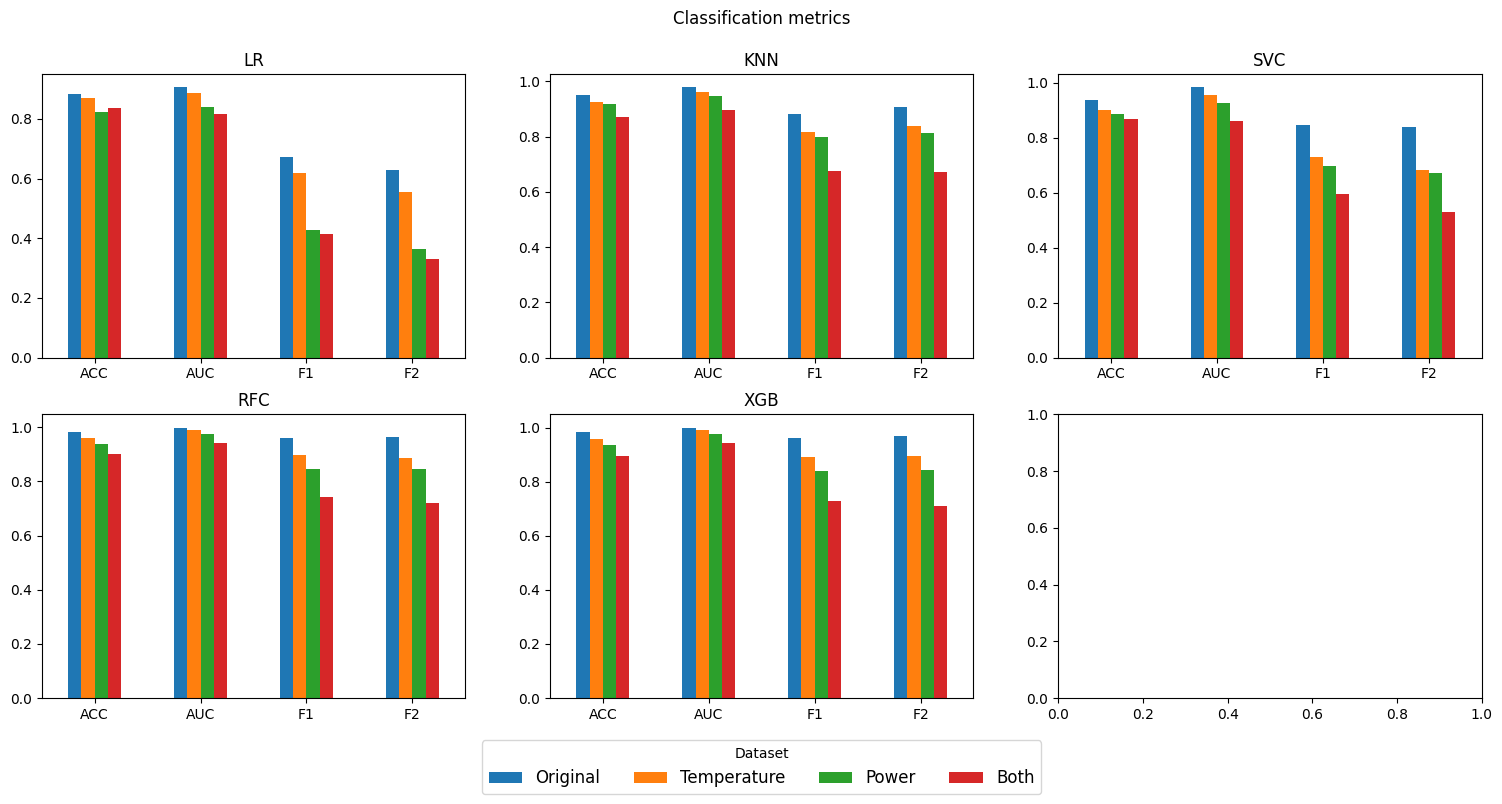

In [79]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier() 
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier() 

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB'] 

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

# Fit on temperature product train
XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature'] = X_val['Process temperature']*X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']     
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']       
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

We observe from the above results that the models perform netter on the original dataset instead of the dataset created after feature selection so we decide to skip the step fro good.


Validation set metrics:
ACC    0.883
AUC    0.905
F1     0.673
F2     0.629
dtype: float64
Test set metrics:
ACC    0.881
AUC    0.917
F1     0.655
F2     0.598
dtype: float64


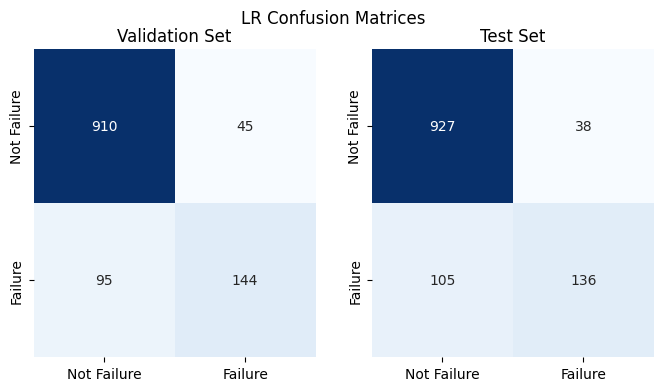

,feature,odds
4,Torque,16.696209
3,Rotational speed,9.394822
1,Air temperature,4.462500
5,Tool wear,3.483306
0,Type,0.520599
2,Process temperature,0.348815


In [80]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
d = {'feature': X_train.columns, 'odds': np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending=False)
odds_df

We see that the last two features are not very relevant for making the prediction.

In [81]:
# Models
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier() 
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

# Parameter grids for GridSearch
knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}
params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                   index=clf)

# Tune hyperparameters with GridSearch (estimated time 8m)
print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 1s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 0m 38s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 1m 33s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, 'objective': 'binary:logistic'}
Training time: 0m 32s


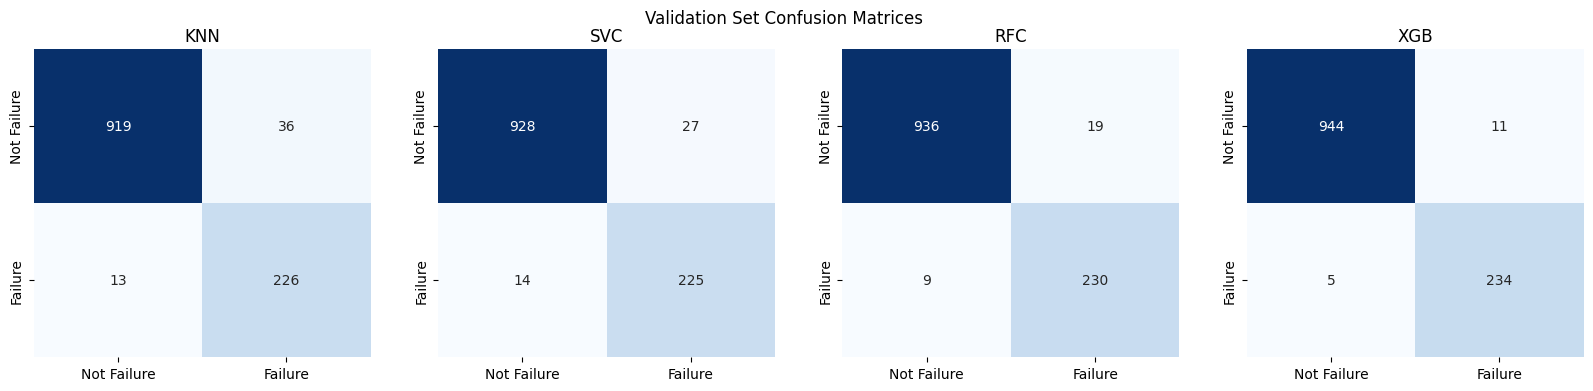

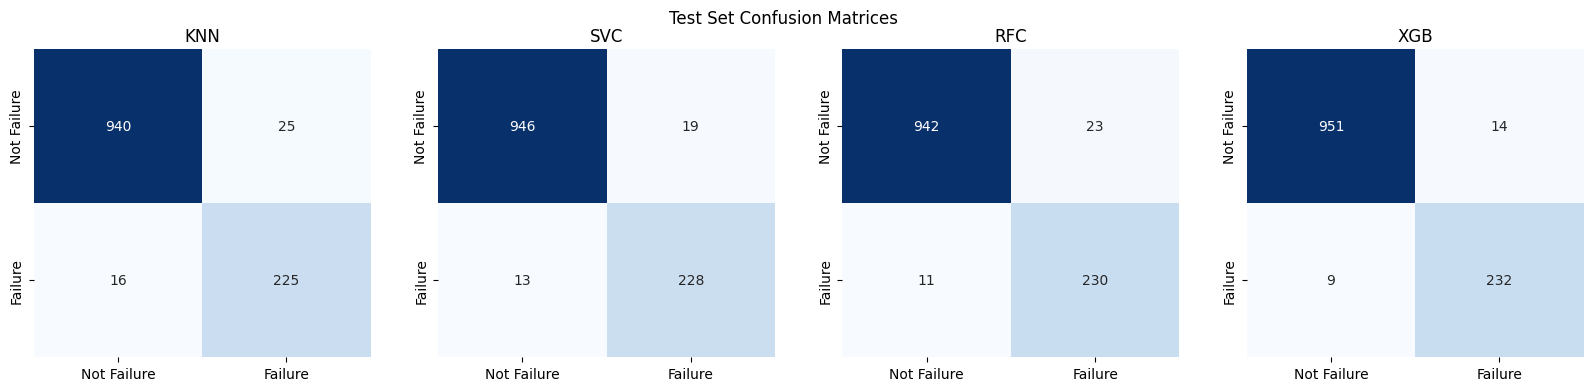


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.959  0.966  0.977  0.987
AUC  0.954  0.987  0.997  0.999
F1   0.902  0.916  0.943  0.967
F2   0.928  0.931  0.954  0.974
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.981
AUC  0.954  0.992  0.997  0.998
F1   0.916  0.934  0.931  0.953
F2   0.927  0.941  0.945  0.959


In [82]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

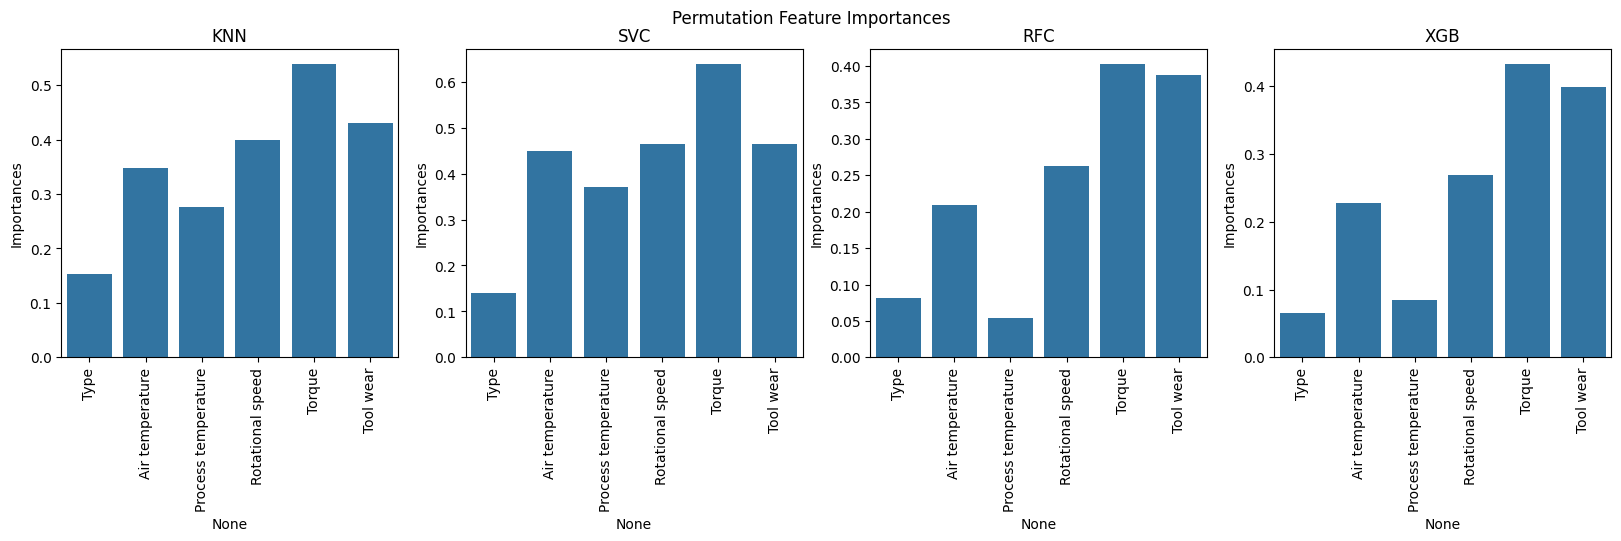

In [83]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train['Target'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

From the above graphs we can see what features were more significant for the calculation of the model.

Now we will proceed to the next task, that is to predict the kind of failure in addition to if the failure will occur. Again we will statr by setting logistic regression as a benchmark and then proceeding with the fitting of the other models.

Validation set metrics:
ACC    0.926
AUC    0.983
F1     0.909
F2     0.919
dtype: float64
Test set metrics:
ACC    0.922
AUC    0.982
F1     0.904
F2     0.914
dtype: float64


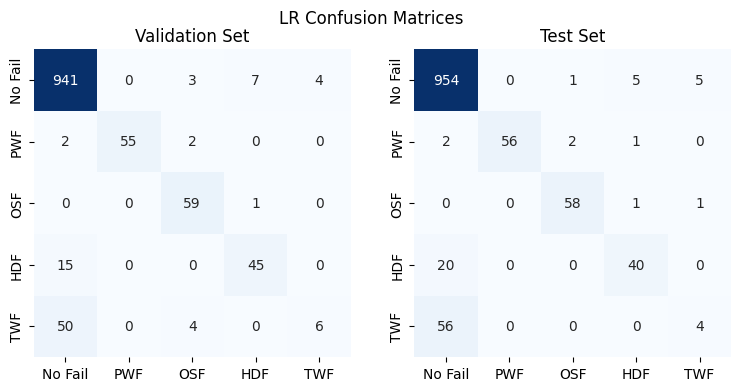

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
No Failure,1.920864,0.224090,2.866848,0.106442,0.059894,0.287084
Power Failure,0.697373,0.824558,0.982471,944.048373,2822.376842,0.744856
Tool Wear Failure,0.036806,0.215535,2.777322,0.108932,8.748803,406.189304
Overstrain Failure,0.636280,4314.687600,0.004253,0.000458,0.398540,0.711005
Heat Dissipation Failure,1.045501,1.337837,0.739732,0.225326,0.118551,749.948357


In [84]:
# multiclass classification
lr = LogisticRegression(random_state=0,multi_class='ovr')
lr.fit(X_train, y_train['Failure Type'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Validation metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'multi_class')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'multi_class')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail','PWF','OSF','HDF','TWF']
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(9,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
odds_df = pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns,
                       index = df_res['Failure Type'].unique())
odds_df

After evaluating the significance of each of the parameter using liner regression we move forward to calculate other models that were described 

In [85]:
# Models
knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'learning_rate':[0.01,0.1],
              'objective':['multi:softprob']}

params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                    index=clf)


# Tune hyperparameters with GridSearch (estimated time 8-10m)
print('GridSearch start')
fitted_models_multi = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'multi_class')
    fitted_models_multi.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 1s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 0m 46s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 1m 37s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time: 1m 57s


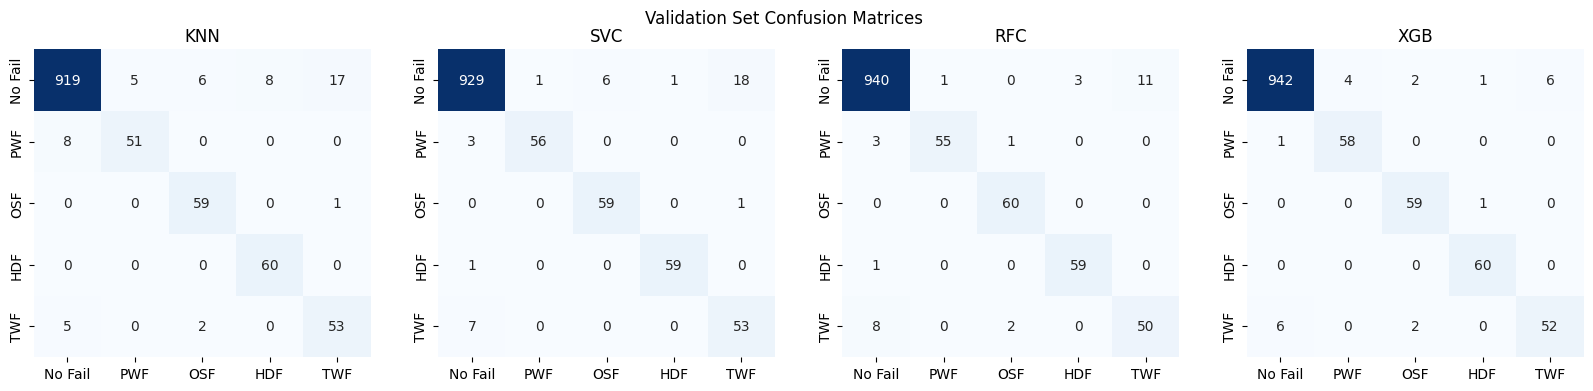

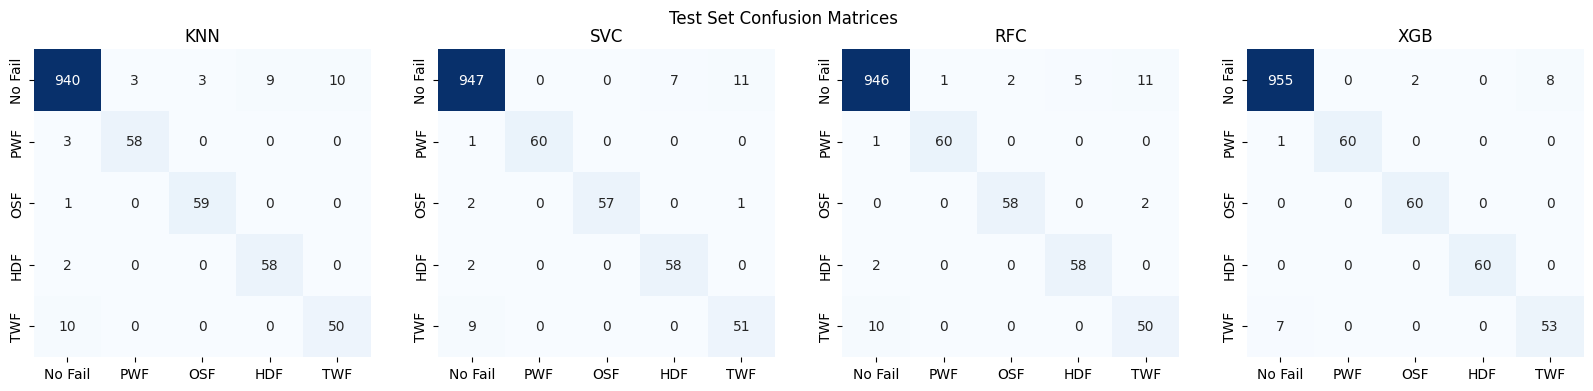


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.956  0.968  0.975  0.981
AUC  0.956  0.993  0.998  0.999
F1   0.957  0.969  0.975  0.981
F2   0.957  0.968  0.975  0.981
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.985
AUC  0.956  0.995  0.997  0.999
F1   0.966  0.973  0.972  0.985
F2   0.966  0.973  0.972  0.985


In [86]:
# Create evaluation metrics

task = 'multi_class'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

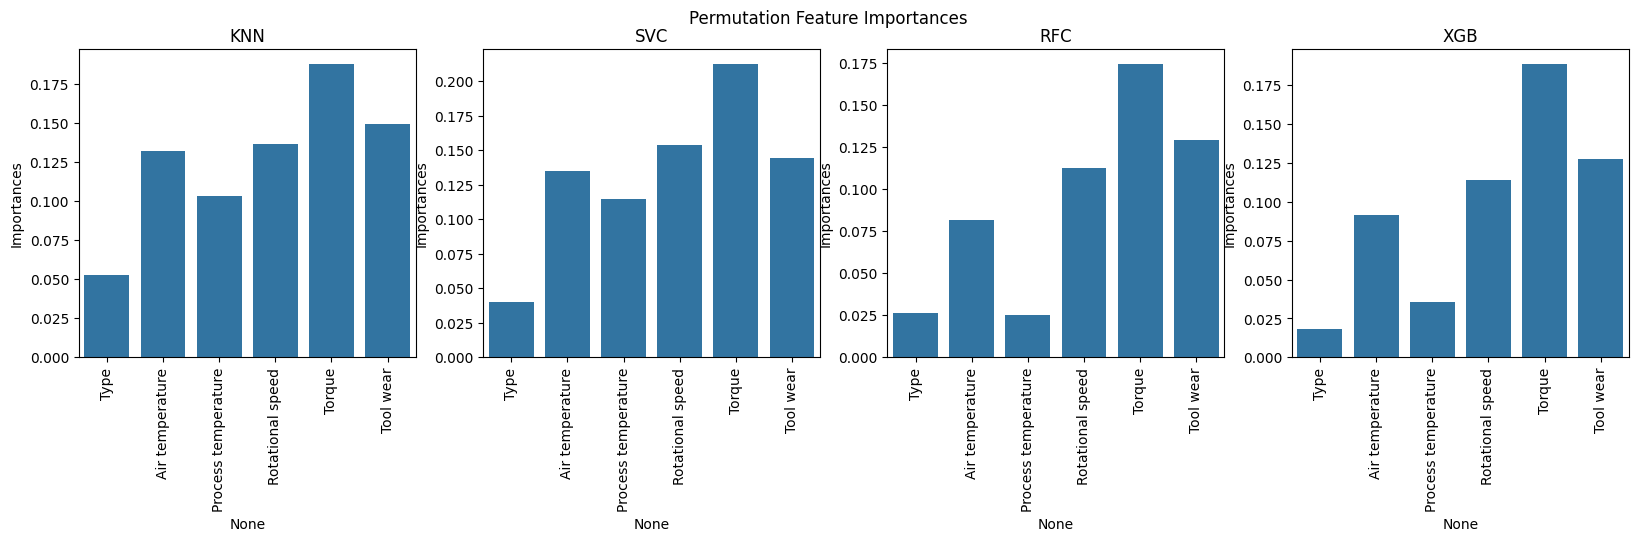

In [87]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
importances = pd.DataFrame()
for clf in fitted_models_multi:
    result = permutation_importance(clf, X_train,y_train['Failure Type'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)

importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

## Conclusion

In conclusion, after thorough analyses and preprocessing, we addressed two tasks: predicting machine failures and identifying the type of failure. The preprocessing involved handling ambiguous samples, applying label encoding to categorical columns, and scaling with StandardScaler. Outliers initially identified played a crucial role in the classification task. PCA revealed that the most influential features are combinations of temperatures, machine power, and tool wear.

Surprisingly, machine type does not significantly impact failure occurrence. The chosen models, particularly XGBoost, perform well for both tasks. XGBoost outperforms KNN in accuracy, although KNN boasts instant response time. The optimal model choice depends on the company's priorities: KNN for speed and XGBoost for accuracy.